In [143]:
from core.semcor_bert_pipeline import *
import pandas as pd

In [144]:
df = pd.read_csv('../data/rabagliati_2013_stimuli.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenize_ctx = lambda t: tokenizer.tokenize(t)
df['tokenized_dis_ctx'] = df['dis_ctx'].apply(tokenize_ctx)

In [145]:
model = initialize_model()

In [185]:
df = df[~df['target'].isin(['moose', 'mousse'])] #BERT tokenization issues

In [186]:
bert_data = []
for i in np.arange(0, len(df.index) - 4, 4):
    type_stimuli = df.iloc[i:i + 4]
    for sent_ctx in ['curr', 'prev']:
        curr_prev_ctx = type_stimuli[type_stimuli['sentence_ctx'] == sent_ctx]
        for row in curr_prev_ctx.iterrows():
            row = row[1]
            s1, s2, target_token = row['s1'], row['s2'], row['target']
            indexed_tokens, tokenized_text = preprocess(s1, target_token, s2 = s2)
            target_activations, attns = get_model_output(indexed_tokens, model)
            attn_dict = process_raw_attentions([attns], [tokenized_text])[0]
            target_embeddings = sum_layers(target_activations, -4)
            bert_data.append({"attns": attn_dict, "target_embed": target_embeddings, "target_name": target_token,
                             "tokenized_sents": tokenized_text[0], "tokenized_dis": row['tokenized_dis_ctx'],
                             "sent_ctx": sent_ctx})

In [187]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1


In [188]:
prev_attn = []
curr_attn = []
prev_layers = []
curr_layers = []
failures = []
for d in bert_data:
    dis_indices = find_sub_list(d['tokenized_dis'], d['tokenized_sents'])
    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1]
        for layer in d['attns']:
            if d['sent_ctx'] == 'prev':
                prev_attn.append(np.sum(d['attns'][layer][dis_start:dis_end]))
                prev_layers.append(layer)
            if d['sent_ctx'] == 'curr':
                curr_attn.append(np.sum(d['attns'][layer][dis_start:dis_end]))
                curr_layers.append(layer)
    else:
        failures.append((d['tokenized_dis'], d['tokenized_sents']))

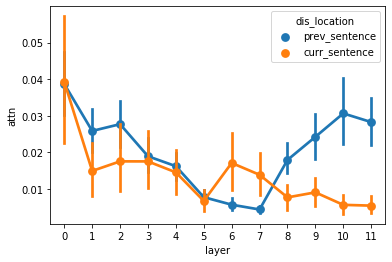

In [195]:
results = pd.DataFrame({"layer": prev_layers + curr_layers, "attn": prev_attn + curr_attn,
              "dis_location": (["prev_sentence"] * len(prev_attn)) + (['curr_sentence'] * len(curr_attn))})
sns.pointplot(x = 'layer', y = 'attn', hue = 'dis_location', data = results)

In [ ]:
prev_attn = []
curr_attn = []
prev_layers = []
curr_layers = []
failures = []
for d in bert_data:
    dis_indices = find_sub_list(d['tokenized_dis'], d['tokenized_sents'])
    if dis_indices is not None:
        dis_start = dis_indices[0]
        dis_end = dis_indices[1]
        for layer in d['attns']:
            if d['sent_ctx'] == 'prev':
                prev_attn.append(np.sum(d['attns'][layer][dis_start:dis_end]))
                prev_layers.append(layer)
            if d['sent_ctx'] == 'curr':
                curr_attn.append(np.sum(d['attns'][layer][dis_start:dis_end]))
                curr_layers.append(layer)
    else:
        failures.append((d['tokenized_dis'], d['tokenized_sents']))